# Training the HATPredict Model

This notebook trains, introspects, and saves a model to predict the **free energy barrier (∆G‡)** of **hydrogen atom transfer (HAT)** reactions of the form:

**A•&nbsp;&nbsp;&nbsp;+&nbsp;&nbsp;&nbsp;B–H&nbsp;&nbsp;&nbsp;→&nbsp;&nbsp;&nbsp;A–H&nbsp;&nbsp;&nbsp;+&nbsp;&nbsp;&nbsp;B•**

where **A•** is a radical species (such as the active radical form of a catalyst) and **B–H** represents a particular bond to hydrogen in the substrate molecule.

To use this model yourself, simply visit [hatpredict.com](http://hatpredict.com).

To learn more about how the input features for the model are computed, or the general chemical problem solved by the model, check out [hatpredict.com/about](http://hatpredict.com/about).

## 1. Python Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8.0, 8.0)

import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster')

import xgboost

from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import shap

sys.path.append('../')
from get_descriptors import write_reaction_descriptors
from get_barriers import split_columns, write_reaction_barriers

## 2.  Compute Input Descriptors for Training and Test Reactions

This model training notebook uses three data sets of HAT reactions.  First, we use a training set (`hong_training_data/smiles.csv`) and a test set (`hong_test_data/smiles.csv`) adapted from Professor Xin Hong's hydrogen atom transfer (HAT) machine learning [paper](https://doi.org/10.1039/D1QO01325D).  Note that this training set contains only 17 different starting radicals **A•**, and that all of the radicals in the test set are also found in the training set; only the substrates are unseen.

Thus, we also use an additional test set (`houk_test_data/smiles.csv`) adapted from Professor Kendall N. Houk's [paper](https://doi.org/10.1021/jacs.2c00389).  Although small, this test data contains three radicals that are _not_ present in the training data, and can thus help us to build a better HAT machine learning model that generalizes not only to new substrates but also to new starting radicals **A•**.

The `smiles.csv` file for each data set contains one reaction per line.  Each reaction contains the SMILES strings of all four reacting species (**A•**, **A–H**, **B•**, and **B–H**) as well as the number of the reacting atom in each of the four species.  Because we are using these data sets to develop the model, each reaction also contains the ground-truth free energy barrier (**∆G‡**) computed via density functional theory which the model is trying to predict.

In the cell below, we compute the input reaction descriptors for each of the three data sets.  For each data set, the reactions are read in from the `smiles.csv` file and the descriptors are output to a `descriptors.csv` file.  Details of how these descriptors are computed can be found in `get_descriptors.py`, from which the `write_reaction_descriptors` function is imported.

Note that this is the most time-consuming part of the machine learning pipeline, so computing all of the descriptors could take about 40 minutes.  (For the big training data set, the later reactions contain species that are common to earlier reactions, so the first ~180 reactions take much longer to compute than subsequent ones.)  At inference time, typically only a few reactions are being computed at a time, so the process is much faster.

Because generating the `descriptors.csv` files is time-consuming, we only generate them if they have not already been generated previously.

In [3]:
# Note: This cell could take about 40 minutes to run if none of the three
# descriptors.csv files have been generated previously.

# Compute and output reaction descriptors for Hong training set
if not os.path.exists('hong_training_data/descriptors.csv'):
    write_reaction_descriptors(in_file = 'hong_training_data/smiles.csv',
                               out_file = 'hong_training_data/descriptors.csv',
                               scratch_dir = 'hong_training_data',
                               verbose = True)

# Compute and output reaction descriptors for Hong test set
if not os.path.exists('hong_test_data/descriptors.csv'):
    write_reaction_descriptors(in_file = 'hong_test_data/smiles.csv',
                               out_file = 'hong_test_data/descriptors.csv',
                               scratch_dir = 'hong_test_data',
                               verbose = True)

# Compute and output reaction descriptors for Houk test set
if not os.path.exists('houk_test_data/descriptors.csv'):
    write_reaction_descriptors(in_file = 'houk_test_data/smiles.csv',
                               out_file = 'houk_test_data/descriptors.csv',
                               scratch_dir = 'houk_test_data',
                               verbose = True)

The cell below imports the input reaction descriptors generated by the previous cell, and splits the columns into input descriptors (`x`), ground-truth outputs (`y`), SMILES strings and atom numbers of the reacting species (`rxns`), and group assignments for cross-validation (`group`).  Details of how the columns are split can be found in `get_barriers.py`, from which `split_columns` is imported.

In [4]:
descriptors_train = pd.read_csv('hong_training_data/descriptors.csv')
descriptors_hong = pd.read_csv('hong_test_data/descriptors.csv')
descriptors_houk = pd.read_csv('houk_test_data/descriptors.csv')

x_train, y_train, rxns_train, group_train = split_columns(descriptors_train)
x_hong, y_hong, rxns_hong, group_hong = split_columns(descriptors_hong)
x_houk, y_houk, rxns_houk, group_houk = split_columns(descriptors_houk)

## 3.  Train an XGBoost Model with Hyperopt

In this section, we train an [XGBoost](https://xgboost.readthedocs.io/en/stable/index.html) model on the training data.  The hyperparameter search is performed via grouped 5-fold cross validation with Bayesian optimization ([Hyperopt](http://hyperopt.github.io/hyperopt/)).  Reactions are assigned to cross-validation groups based on the identity of their substrate **B-H**.  (Note that this means that every starting radical **A•** is likely present in every cross validation fold, which likely reduces the ability of the model to generalize to new starting radicals.  As discussed below with the results, although the performance on unseen starting radicals remains decent, we are working to further alleviate this issue in the next generation of HATPredict by expanding the training data.)

The loss to be minimized is the average, over all 5 validation sets, of the root mean square error (RMSE) of the predicted free energy barriers (∆G‡) in units of kcal/mol.

The cell below defines and prepares the training process.

In [5]:
# Construct DMatrix to use xgboost
xgb_train = xgboost.DMatrix(x_train.values, label=y_train.values)

# Split training data based on groups for 5-fold cross-validation
gkf = list(GroupKFold(n_splits=5).split(x_train, y_train, group_train))

# Define the hyperparameter space to be searched with Hyperopt
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': hp.quniform('max_depth', 1, 12, 1),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'reg_alpha': hp.loguniform('alpha', -10, 10),
    'num_boost_round': hp.quniform('num_boost_round', 1, 1000, 1),
}

def hyperparameter_tuning_cv(space):
    """
    Hyperparameter tuning function to be optimized via cross-validation.

    Arguments:

        - space: a dictionary whose keys are hyperparameters to be searched,
                 and whose values are distributions to search over

    Returns:

        - a dictionary with the following keys:

            - 'loss': the loss function to be minimized over the hyperparameter
                      space

            - 'loss_variance': optionally an estimate of the variance of this
                               loss function

            - 'status': STATUS_OK indicating the loss was properly computed for
                        a set of hyperparameters
    """

    # Define hyperparameters for xgboost.cv, with reference to the space of
    # hyperparameters being searched over
    param_grid = {
        'max_depth': int(space['max_depth']),
        'gamma': space['gamma'],
        'reg_alpha': space['reg_alpha'],
        'min_child_weight': space['min_child_weight'],
        'subsample': space['subsample'],
        'learning_rate': space['learning_rate'],
        'colsample_bytree': space['colsample_bytree'],
        'eval_metric': 'rmse',
        'seed': 42,
        'nthread': -1
    }

    # Perform cross-validation for the set of hyperparameters in param_grid
    xgb_cv = xgboost.cv(param_grid,
                        xgb_train,
                        num_boost_round=int(space['num_boost_round']),
                        folds=gkf)

    # Extract the loss and an estimate of the variance of the loss from
    # cross-validation
    rmse_mean = xgb_cv['test-rmse-mean'].iloc[-1]
    rmse_var = (xgb_cv['test-rmse-std'].iloc[-1])**2

    return {'loss': rmse_mean, 'loss_variance': rmse_var, 'status': STATUS_OK}

The cell below actually carries out model training with Bayesian optimization using XGBoost with cross-validation, and prints out the best hyperparameters that minimize the loss.  It may take 1-2 hours to run.

In [6]:
# Define a Trials object to store the results of the hyperparameter search
trials_cv = Trials()

# Use Hyperopt to optimize the hyperparameters
best_params_hyperopt = fmin(
    fn=hyperparameter_tuning_cv,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials_cv,
    rstate=np.random.default_rng(23),
    #timeout=60*30                       # Timeout after 30 minutes, comment out when not testing
)

100%|██████████| 100/100 [29:48<00:00, 17.89s/trial, best loss: 1.2086386716701985]


Here are the best hyperparameters found with Hyperopt:

In [7]:
best_params_hyperopt

{'alpha': 0.12892236413543154,
 'colsample_bytree': 0.861646157432882,
 'gamma': 0.030361182492408725,
 'learning_rate': 0.012106421733770278,
 'max_depth': 8.0,
 'min_child_weight': 1.0829360817170066,
 'num_boost_round': 951.0,
 'subsample': 0.5007026951438933}

We collect the best parameters obtained with Hyperopt (as well as a few options that were not searched) and retrain the model on the entire training data set.

In [8]:
# Best hyperparameters found with Hyperopt
best_params = best_params_hyperopt.copy()

best_params['max_depth'] = int(best_params['max_depth'])
best_params['eval_metric'] = 'rmse'
best_params['seed'] = 42
best_params['nthread'] = -1

n_rounds = int(best_params.pop('num_boost_round'))

xgb_final = xgboost.train(best_params, xgb_train, num_boost_round=n_rounds)

## 4.  Model Results

In this section, we investigate the results of the Bayesian-optimized XGBoost model.  In particular, we analyze the performance of the model on the training set (`descriptors_train`) and both test sets (`descriptors_hong` and `descriptors_houk`).

Below is a helper functions for plotting model results.

In [9]:
def plot_results(y_true, y_pred, min_lim=7, max_lim=29,
                 hue=None, hue_labels=None):
    """
    Function which plots ML-predicted barriers (y-axis) vs. ground-truth
    DFT-computed barriers (x-axis).

    Arguments:

        - y_true: Pandas series whose entries correspond to the ground-truth
                  DFT-computed free energy barriers for hydrogen atom transfer
                  reactions

        - y_pred: Pandas series whose entries correspond to the ML-predicted
                  free energy barriers for hydrogen atom transfer reactions

        - min_lim: Int or float with the minimum limit for the x-axis and
                   y-axis (in kcal/mol)

        - max_lim: Int or float with the maximum limit for the x-axis and
                   y-axis (in kcal/mol)

        - hue: An optional Pandas series whose entries contain labels according
               to which points are to be colored

        - hue_labels: An optional list of labels corresponding to the different
                      hues (need to experiment to get this list in the correct
                      order)

    Returns:

        Nothing
    """

    fig, ax = plt.subplots()

    # Scatterplot of ML-computed barriers (y-axis) vs.
    # ground-truth DFT-computed barriers (x-axis)
    sns.scatterplot(x=y_true, y=y_pred, hue=hue, ax=ax)
    ax.set_xlabel('DFT-Computed Barrier (kcal/mol)')
    ax.set_ylabel('HATPredict Barrier (kcal/mol)')
    ax.set_xticks(range(2*(min_lim // 2), 2*(max_lim//2 + 1), 2))
    ax.set_yticks(range(2*(min_lim // 2), 2*(max_lim//2 + 1), 2))
    ax.set_xlim(min_lim, max_lim)
    ax.set_ylim(min_lim, max_lim)

    # If hue labels are provided, put them on the legend to identify the
    # meaning of the color of each point
    if hue_labels is not None:
        ax.legend(loc='lower right', labels=['_nolegend_'] + hue_labels)
    # Otherwise remove the legend
    else:
        ax.legend([], [], frameon=False)

    # Add a black dashed y = x line; for a good model points should fall
    # near this line
    x = np.linspace(min_lim, max_lim, 100)
    ax.plot(x, x, color='black', ls='--')

    # Add yellow bands extending 1.4 kcal/mol above and below the y = x line;
    # points within this region correspond to reaction rates predicted
    # correctly to within a factor of 10
    bandwidth = 1.4
    ax.fill_between(x, x+bandwidth, x-bandwidth, alpha=0.2, color='yellow')

    # Compute accuracy statistics
    R2 = r2_score(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    # Display accuracy statistics on graph
    ax.text(0.02, 0.98,
            'R$^2$ = %.2f\nMAE = %.2f kcal/mol\nRMSE = %.2f kcal/mol' % (R2, MAE, RMSE),
            verticalalignment='top', transform=ax.transAxes)

For Xin Hong's original training data (`descriptors_train`), we plot the predicted free energy barriers from the model versus the ground-truth free energy barriers from density functional theory (DFT) transition state computations.

In this plot, and all others that follow, the highlighted yellow area corresponds to free energy barrier predictions that are correct to within 1.4 kcal/mol.  This corresponds to estimating a reaction rate constant correctly to within a factor of 10 at room temperature, which is the most common benchmark used in quantum chemistry to determine the accuracy of a computational method.

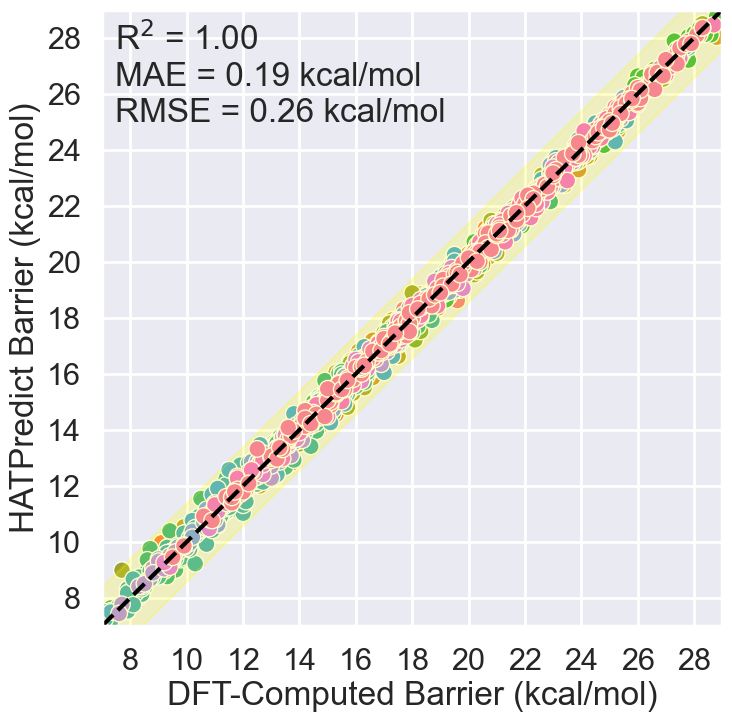

In [10]:
# Xin Hong Training Set
y_train_pred = pd.Series(xgb_final.predict(xgboost.DMatrix(x_train)))
plot_results(y_train, y_train_pred,
             hue=rxns_train['AR_smiles'])

We now plot the results of the model on our two test sets.  First, we plot the results for Xin Hong's original test data (`descriptors_hong`).  Recall that every catalyst in Xin Hong's test data is also present in the training data; only the substrates are unseen.

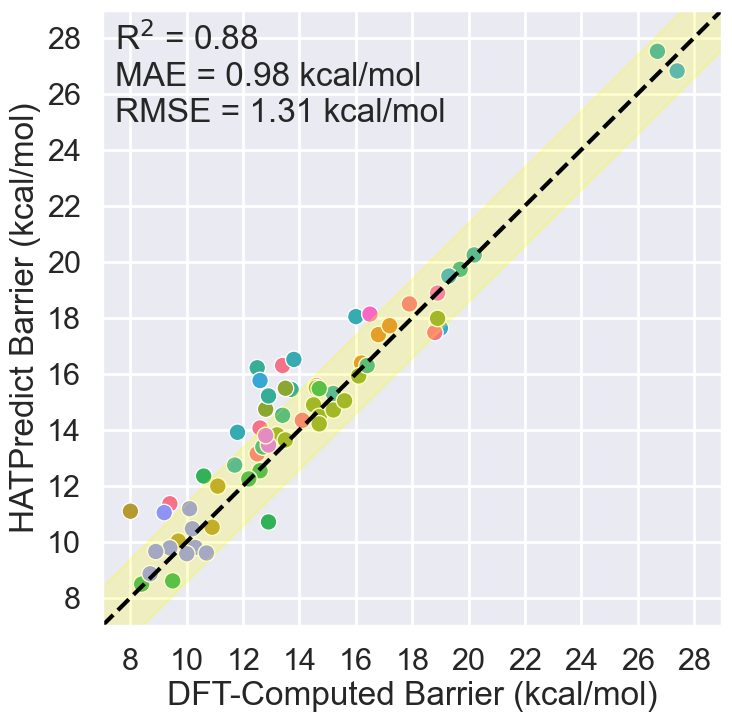

In [11]:
# Xin Hong Test Set
y_hong_pred = pd.Series(xgb_final.predict(xgboost.DMatrix(x_hong)))
plot_results(y_hong, y_hong_pred,
             hue=rxns_hong['AR_smiles'])

Second, we plot the results for test data adapted from Kendall N. Houk (`descriptors_houk`).  Note that this data set, while small, contains three (out of four) catalysts that are not present in the training data (the t-BuO· catalyst is present in the training data).

The label '_nolegend_' of <matplotlib.collections.PathCollection object at 0x7f7e0727f970> starts with '_'. It is thus excluded from the legend.


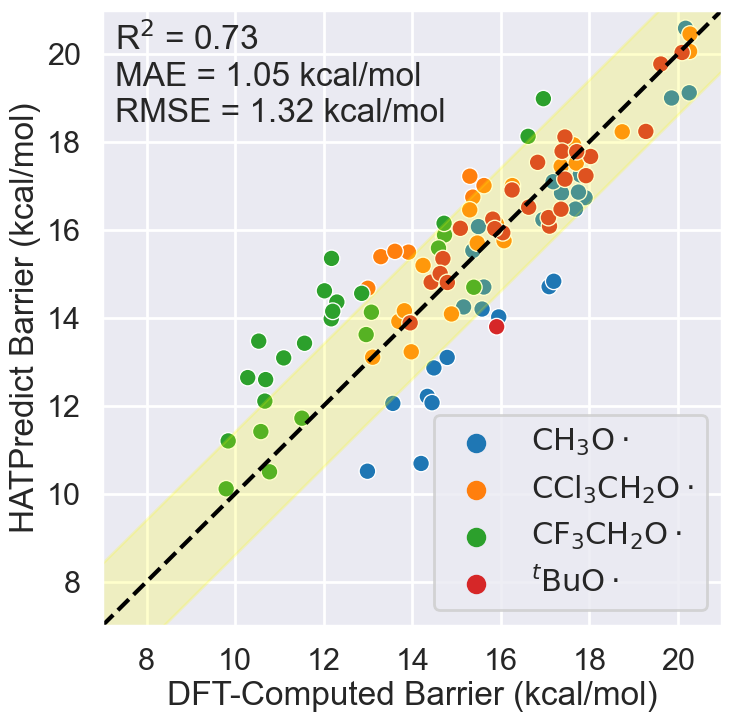

In [12]:
# Houk Test Set
labels_houk = [r'$\mathrm{CH}_3\mathrm{O}\cdot$',
               r'$\mathrm{CCl}_3\mathrm{CH}_2\mathrm{O}\cdot$',
               r'$\mathrm{CF}_3\mathrm{CH}_2\mathrm{O}\cdot$',
               r'$^t\mathrm{BuO}\cdot$']
y_houk_pred = pd.Series(xgb_final.predict(xgboost.DMatrix(x_houk)))
plot_results(y_houk, y_houk_pred, max_lim=21,
             hue=rxns_houk['AR_smiles'], hue_labels=labels_houk)

The model performs better on the training data (`descriptors_train`) than on either of the two test sets, suggesting some overfitting to the training data, although the performance on the test sets is still excellent and within normal standards for chemical accuracy.

Moreover, we observe that the model performs better on Xin Hong's test data (`descriptors_hong`) than on Kendall N. Houk's test data (`descriptors_houk`).  Since `descriptors_houk` contains unseen catalysts, but `descriptors_hong` does not, we hypothesize that the model is somewhat overfitted to the starting radicals **A•** that are present in the training data.

Thus, we are currently collecting additional training data on hydrogen atom transfer (HAT) reactions with more than 20 new starting radicals **A•**.  The goal is to expand the number of starting radicals on which the model is trained, as well as the size of the training set overall, and to construct validation sets which have no overlap in any reaction species with the training data.  We expect that this will reduce overfitting and yield an even more accurate next generation of HATPredict.

## 5. Model Introspection

Finally, we use [SHAP values](https://shap.readthedocs.io/en/latest/index.html) (SHapley Additive exPlanations), based on Shapley values, to investigate which features are most important in the final model for predicting the free energy barrier (∆G‡) of hydrogen atom transfer (HAT) reactions.

The bar graph below displays the mean absolute value of the SHAP value for the 20 most important input features, averaged over the entire training data set (`descriptors_train`).  This value represents, on average, how much each feature changes the magnitude of ∆G‡ (in either direction) in kcal/mol.

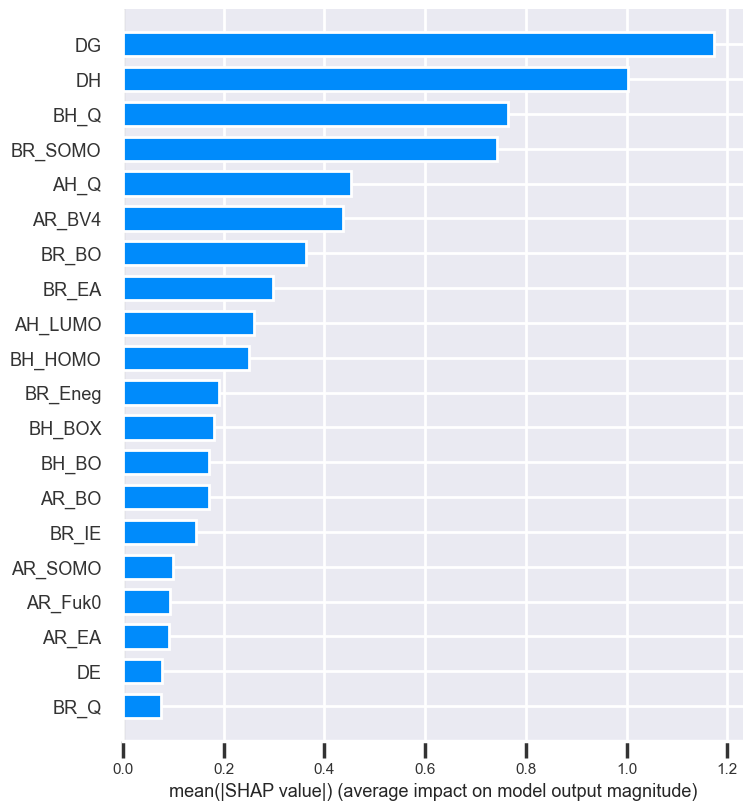

In [13]:
# Compute SHAP values using shap for the training data
explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(xgb_train)

# Plot the SHAP values for the top 20 input features averaged over each
# reaction in the training data
shap.summary_plot(shap_values, x_train, plot_type="bar")

Recall the form of our hydrogen atom transfer (HAT) reaction:

**A•&nbsp;&nbsp;&nbsp;+&nbsp;&nbsp;&nbsp;B–H&nbsp;&nbsp;&nbsp;→&nbsp;&nbsp;&nbsp;A–H&nbsp;&nbsp;&nbsp;+&nbsp;&nbsp;&nbsp;B•**

The two most important features for predicting the free energy barrier for the reaction (∆G‡) are the overall free energy of reaction (∆G_rxn) and the overall enthalpy of reaction (∆H_rxn), consistent with [established studies](https://doi.org/10.1021/jacs.2c00389) of the Evans-Polanyi principle applied to hydrogen atom transfer (HAT) reactions.

Thus, the most important features in the final machine learning model, as quantified by SHAP values, are consistent with known and intuitive chemical explanations.

## 6. Save the Model

We conclude by saving the trained model as a `.json` file so that it can be used by the chemical community to predict the free energy barriers (∆G‡) of their own hydrogen atom transfer (HAT) reactions.

In [14]:
xgb_final.save_model('../xgb_model.json')

For good measure, we also save the predicted barriers for each of the three data sets.  For each data set, the descriptors are read in from the `descriptors.csv` file and the predicted barriers are output to a `barriers.csv` file.  Details can be found in `get_barriers.py`, from which the `write_reaction_barriers` function is imported.

In [15]:
# Compute and save predicted reaction barriers for Hong training set
write_reaction_barriers(in_file = 'hong_training_data/descriptors.csv',
                        out_file = 'hong_training_data/barriers.csv',
                        model_file = '../xgb_model.json')

# Compute and save predicted reaction barriers for Hong test set
write_reaction_barriers(in_file = 'hong_test_data/descriptors.csv',
                        out_file = 'hong_test_data/barriers.csv',
                        model_file = '../xgb_model.json')

# Compute and save predicted reaction barriers for Houk test set
write_reaction_barriers(in_file = 'houk_test_data/descriptors.csv',
                        out_file = 'houk_test_data/barriers.csv',
                        model_file = '../xgb_model.json')

Please visit [hatpredict.com](http://hatpredict.com) to use this model!  There is no need to install anything!